# Comparison of taxa and land use

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import husl
from random import shuffle
from legendgram import legendgram
import mapclassify
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [2]:
clusters = pd.read_csv('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Clustering/complete data/200218_clusters_complete_n20.csv', index_col=0)

In [3]:
landuse = pd.read_csv('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Validation/land_use.csv', index_col=0)

In [5]:
landuse.KOD.unique().shape

(123,)

In [4]:
joined = clusters.merge(landuse[['uID', 'KOD']], on='uID', how='left')

In [5]:
joined.head(4)

uID  cluster  KOD
0    0        1  PRR
1    1       11   BD
2    2       13  BRR
3    3       18  BRR

In [5]:
counts = joined.KOD.value_counts()

In [49]:
counts[counts>1000].index

Index(['BRR', 'BD', 'ZHB', 'BRV', 'PND', 'SLK', 'SAM', 'PRR', 'BQ', 'SLU',
       'RAZ', 'XO', 'PRS', 'SQ', 'ZHV'],
      dtype='object')

Landuse is not a great resource, but there is a clear link between taxa and use.

In [20]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50), (75, 90, 85), (347, 72, 60), (246, 79, 60)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=5)
    for rgb in pal[1:]:
        cols.append(rgb)
symbology = {0: cols[10],
             1: cols[14],
             2: cols[20],
             3: cols[9],
             4: cols[22],
             5: cols[1],
             6: cols[18],
             7: cols[23],
             8: cols[11],
             9: cols[21],
             10: cols[0],
             11: cols[3],
             12: cols[7],
             13: cols[22],
             14: cols[6],
             15: cols[2],
             16: cols[19],
             17: cols[23],
             18: cols[17],
             19: cols[15]}

In [20]:
brr = joined[joined.KOD == 'BRR']

Text(0.5, 0, 'cluster')

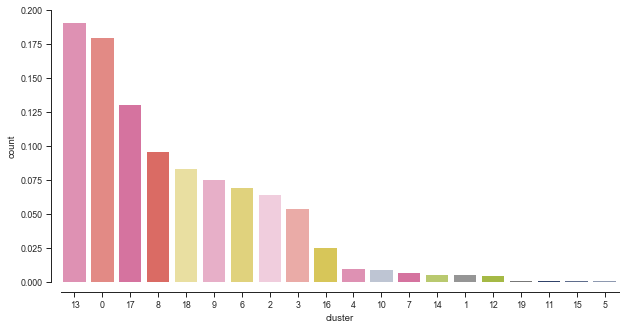

In [36]:
counts = brr.cluster.value_counts(normalize=True)

sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, x=counts.index, y=counts, order=counts.index, palette=symbology)
sns.despine(offset=10)
plt.ylabel('count')
plt.xlabel('cluster')

In [29]:
bd = joined[joined.KOD == 'BD']

Text(0.5, 0, 'cluster')

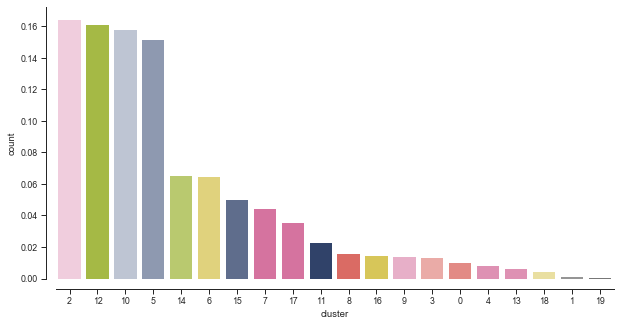

In [37]:
counts = bd.cluster.value_counts(normalize=True)

sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, x=counts.index, y=counts, order=counts.index, palette=symbology)
sns.despine(offset=10)
plt.ylabel('count')
plt.xlabel('cluster')

Text(0.5, 0, 'cluster')

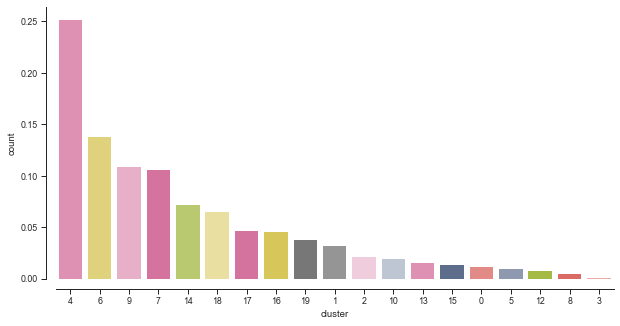

In [38]:
s = joined[joined.KOD == 'PND']

counts = s.cluster.value_counts(normalize=True)

sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, x=counts.index, y=counts, order=counts.index, palette=symbology)
sns.despine(offset=10)
plt.ylabel('count')
plt.xlabel('cluster')

In [11]:
buildings = gpd.read_file('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Clustering/geometry.gpkg', layer='buildings')

In [12]:
buildings = buildings.merge(joined, on='uID', how='left')

In [25]:
def north_arrow(f, ax, rotation=0, loc=2, legend_size=(.1,.1), frameon=False, thick=.1, outline=3, edgecolor='k', facecolor='k'):
    from legendgram.util import make_location
    from matplotlib.transforms import Affine2D
    
    arrpos = make_location(ax, loc, legend_size=legend_size)
    arrax = f.add_axes(arrpos)

    circle = plt.Circle((0, 0), radius=1, edgecolor=edgecolor, facecolor='w', linewidth=outline)
    arrax.add_patch(circle)

    rectangle = plt.Rectangle((-0.05, 0), thick, 1, facecolor=facecolor)
    t = Affine2D().rotate_deg(rotation) + arrax.transData
    rectangle.set_transform(t)
    arrax.add_patch(rectangle)
    arrax.axis('scaled')
    arrax.set_frame_on(frameon)
    arrax.get_yaxis().set_visible(False)
    arrax.get_xaxis().set_visible(False)
    return arrax

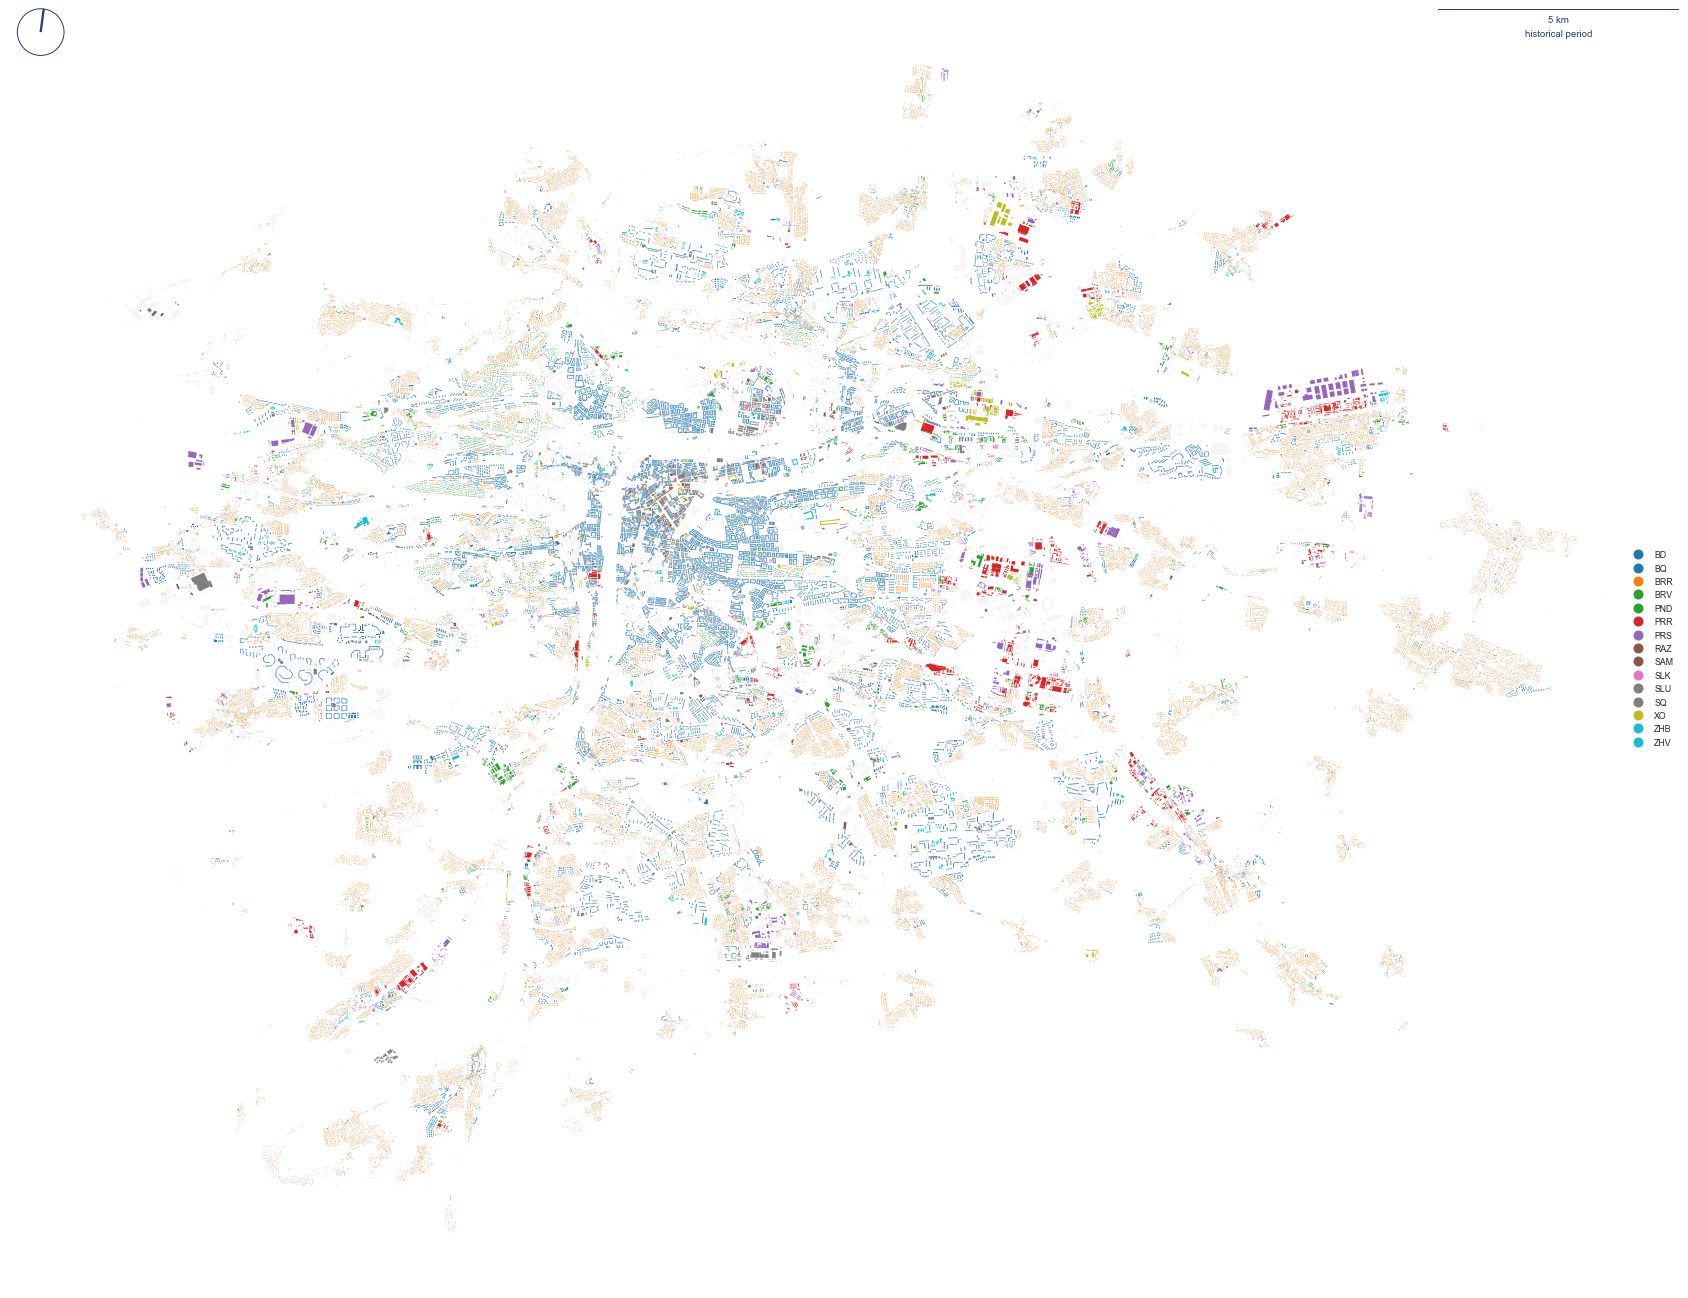

In [52]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  

ax = buildings[buildings.KOD.isin(counts[counts>1000].index)].plot('KOD', categorical=True, figsize=(30, 30), legend=True,
                   legend_kwds=dict(loc='center right', frameon=False))
buildings[~buildings.KOD.isin(counts[counts>1000].index)].plot(ax=ax, color='whitesmoke')
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
#for ext in ['pdf', 'png']:
#    plt.savefig('figures/PRG_origin.' + ext, bbox_inches='tight')

# get the most frequent use within 3 steps

In [64]:
import libpysal

from tqdm import tqdm

In [56]:
spatial_weights = libpysal.io.open('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Clustering/queen3_uID.gal', 'r').read()
spatial_weights.neighbors = {int(k): [int(i) for i in v] for k, v in spatial_weights.neighbors.items()}

/Users/martin/anaconda3/envs/geo_dev/lib/python3.8/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 128 disconnected components.
  warnings.warn(message)


In [13]:
buildings = buildings.set_index('uID')

In [75]:
results = []
for index, row in tqdm(buildings.iterrows(), total=buildings.shape[0]):
    try:
        neighbours = spatial_weights.neighbors[index].copy()
        neighbours.append(index)

        uses = buildings.loc[neighbours]['KOD']
        results.append(uses.value_counts().index[0])
    except:
        results.append(None)
buildings['land_use_3'] = results    

100%|██████████| 140408/140408 [04:36<00:00, 507.72it/s]


In [77]:
buildings['land_use_3'].to_csv('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Validation/land_use_interpolated.csv')

In [5]:
interp = pd.read_csv('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Validation/land_use_interpolated.csv', index_col=0)
interp

land_use_3
uID              
0             PRR
1              BD
2             BRR
3             BRR
4              BD
...           ...
140457         BD
140458        BRR
140459         BD
140460         BD
140461        BRR

[140408 rows x 1 columns]

In [6]:
buildings['land_use_3'] = interp

NameError: name 'buildings' is not defined

In [7]:
buildings

NameError: name 'buildings' is not defined

In [25]:
counts = buildings.land_use_3.value_counts()

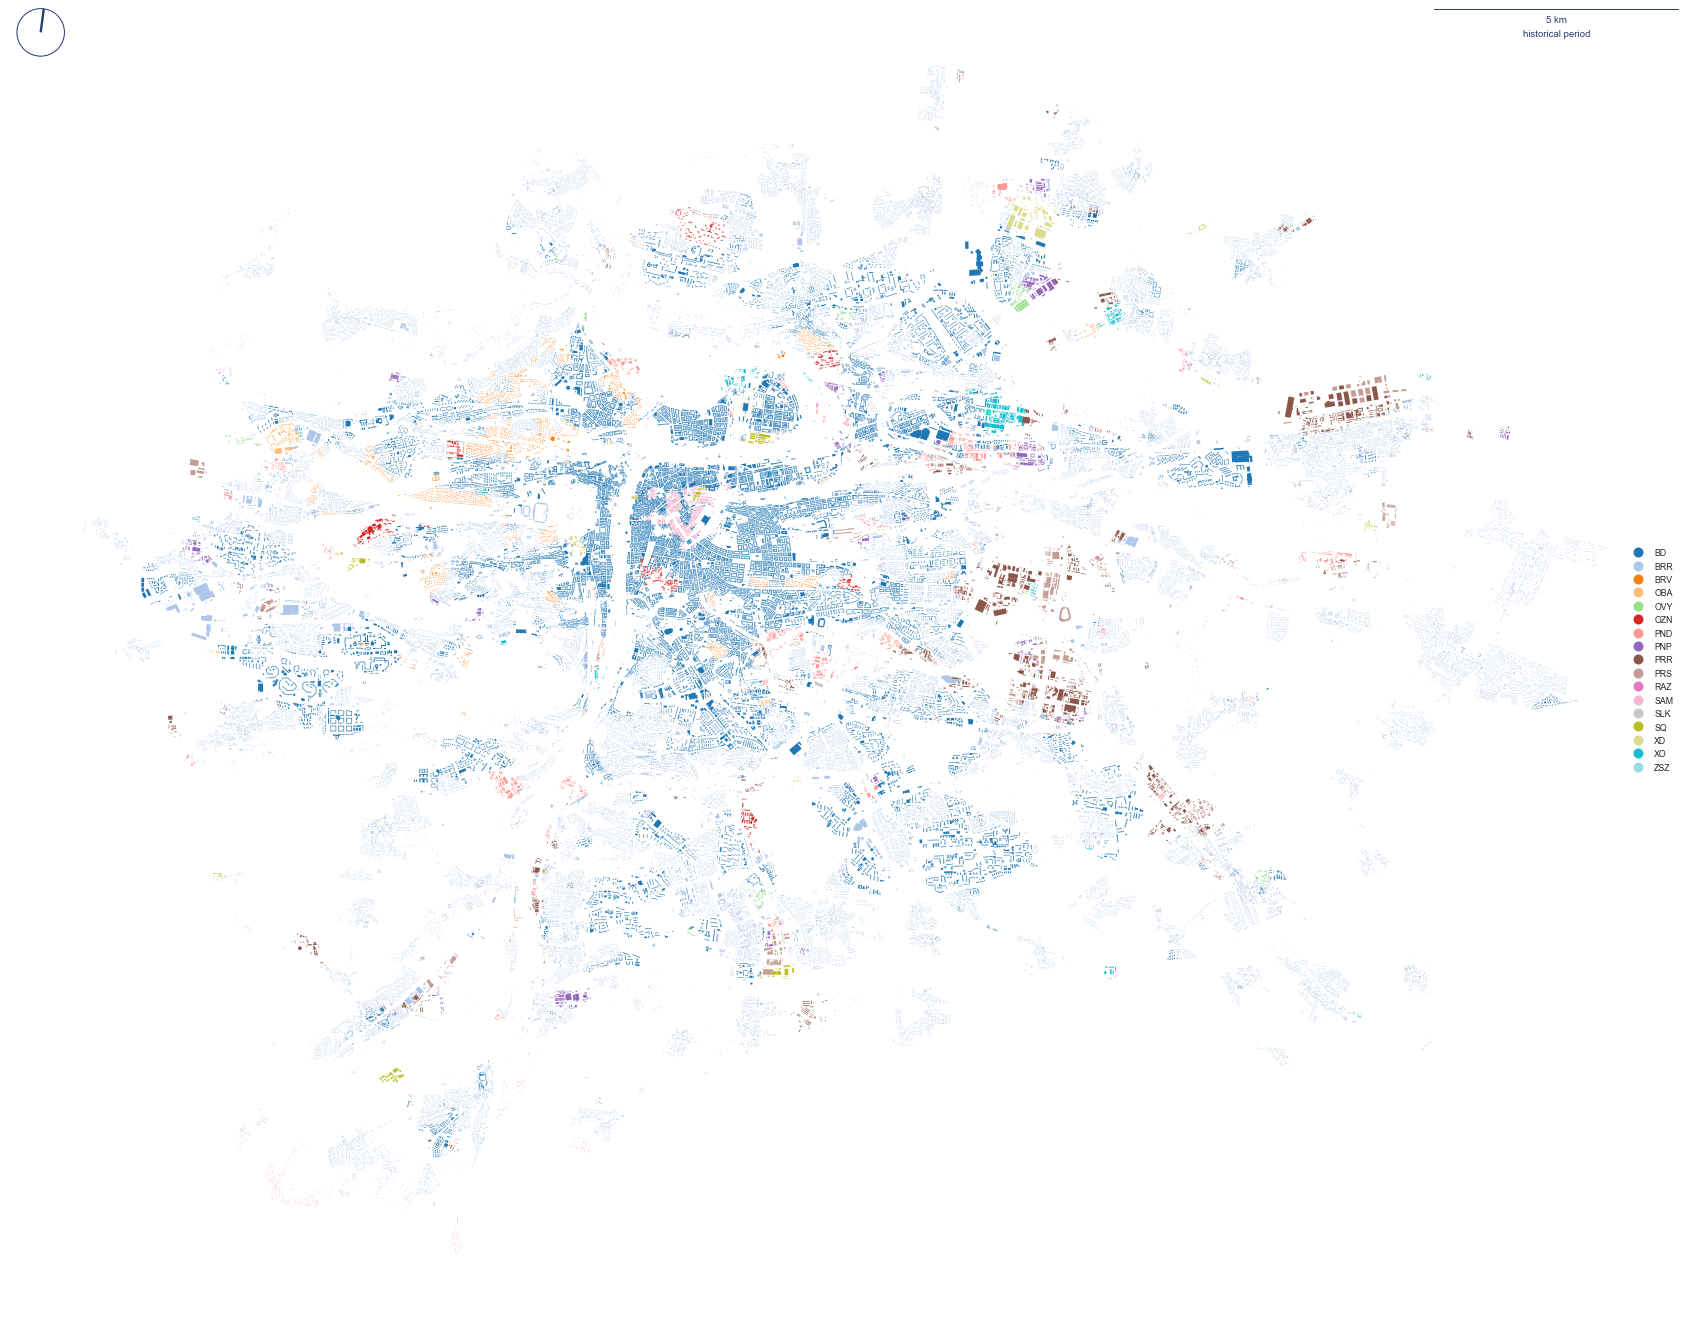

In [89]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  

ax = buildings[buildings.land_use_3.isin(counts[counts>200].index)].plot(
    'land_use_3', categorical=True, figsize=(30, 30), legend=True,
                   legend_kwds=dict(loc='center right', frameon=False), cmap='tab20')
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
#for ext in ['pdf', 'png']:
#    plt.savefig('figures/PRG_origin.' + ext, bbox_inches='tight')

In [19]:
counts[counts>1400]

BRR    84085
BD     39963
BRV     2965
PRR     2035
PND     1557
Name: land_use_3, dtype: int64

In [99]:
[use for use in buildings.land_use_3 if use in counts[counts>1400].index else 'other']

SyntaxError: invalid syntax (<ipython-input-99-618c420112d5>, line 1)

In [26]:
generalised = []
major = counts[counts>1400].index
for _, use in buildings.land_use_3.iteritems():
    if use in major:
        generalised.append(use)
    else:
        generalised.append('other')

In [27]:
buildings['lu_gen'] = generalised

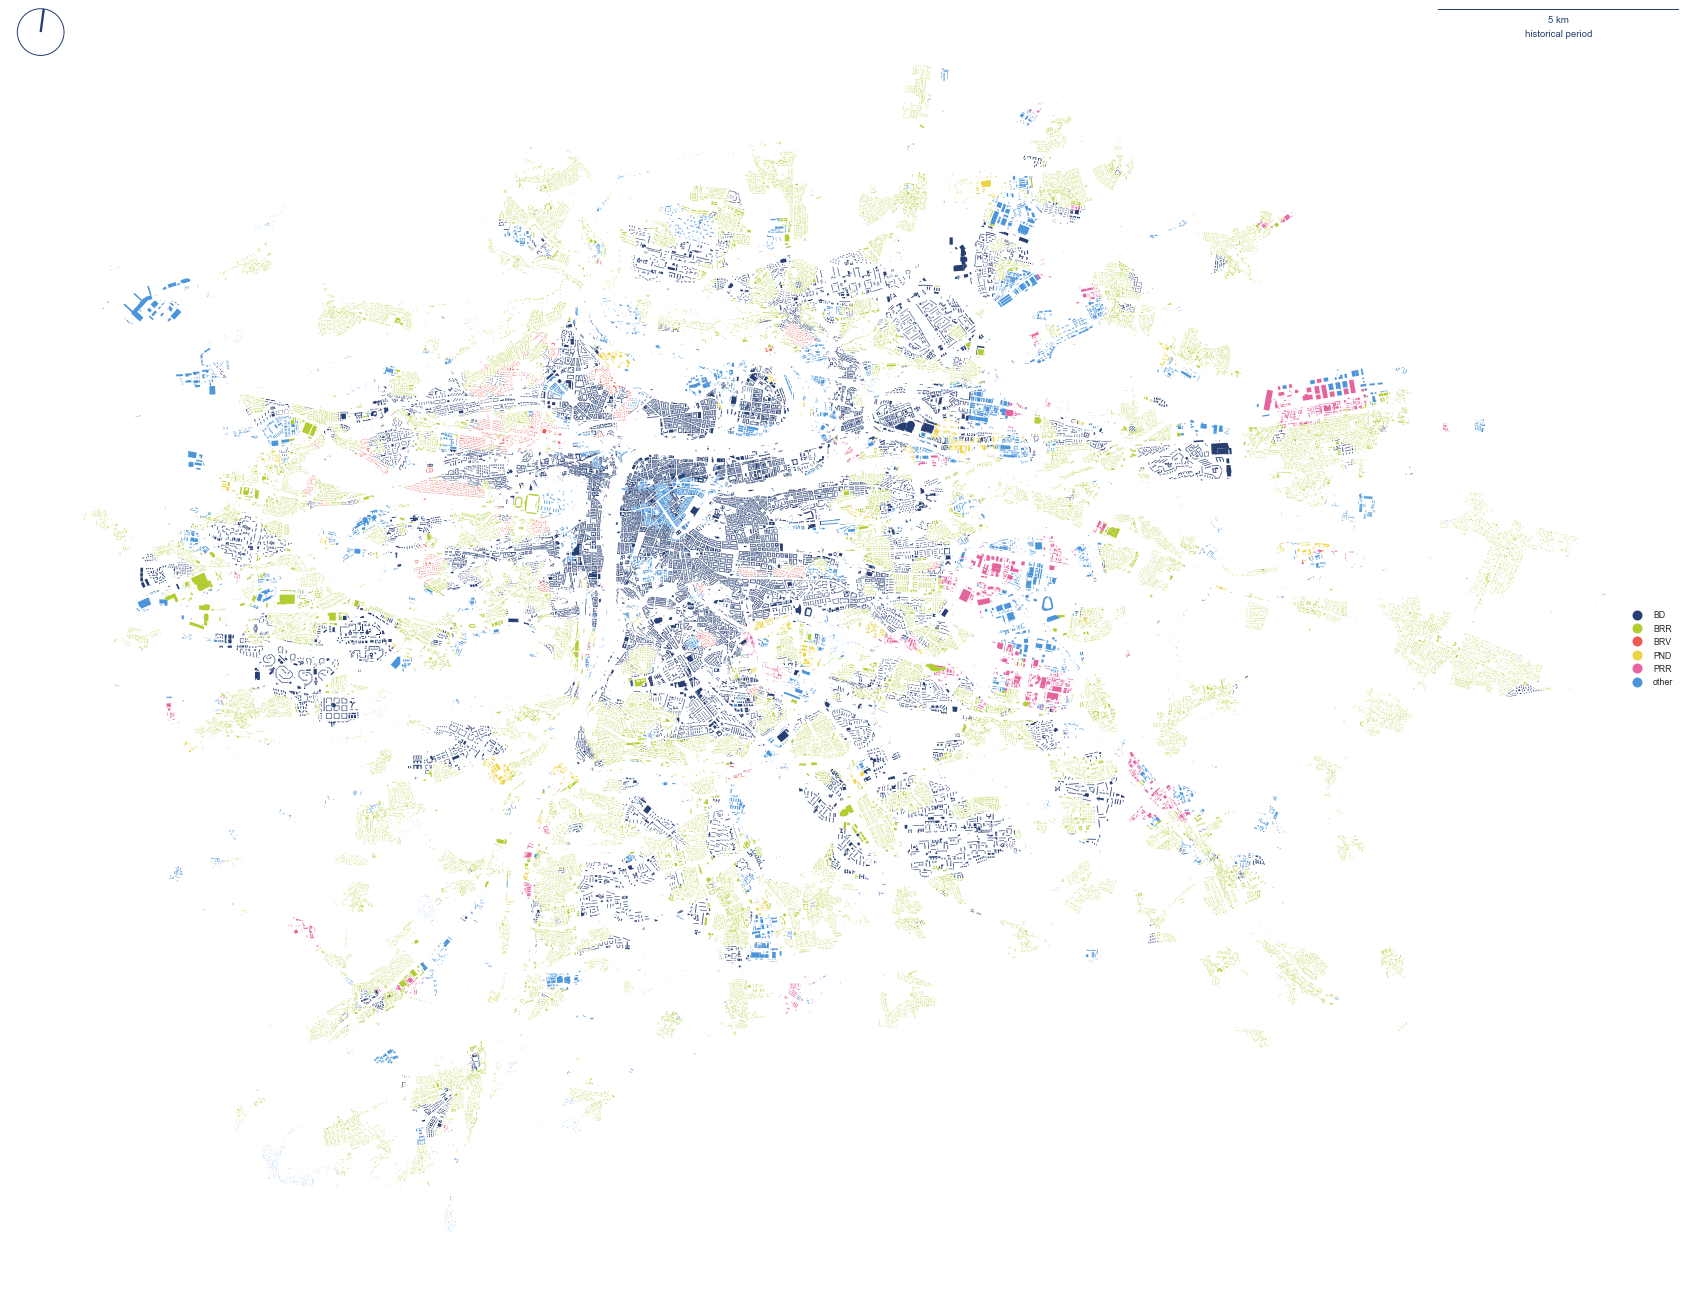

In [105]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  

ax = buildings.plot(
    'lu_gen', categorical=True, figsize=(30, 30), legend=True,
                   legend_kwds=dict(loc='center right', frameon=False), cmap=cmap)
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
for ext in ['pdf', 'png']:
    plt.savefig('figures/PRG_land_use.' + ext, bbox_inches='tight')

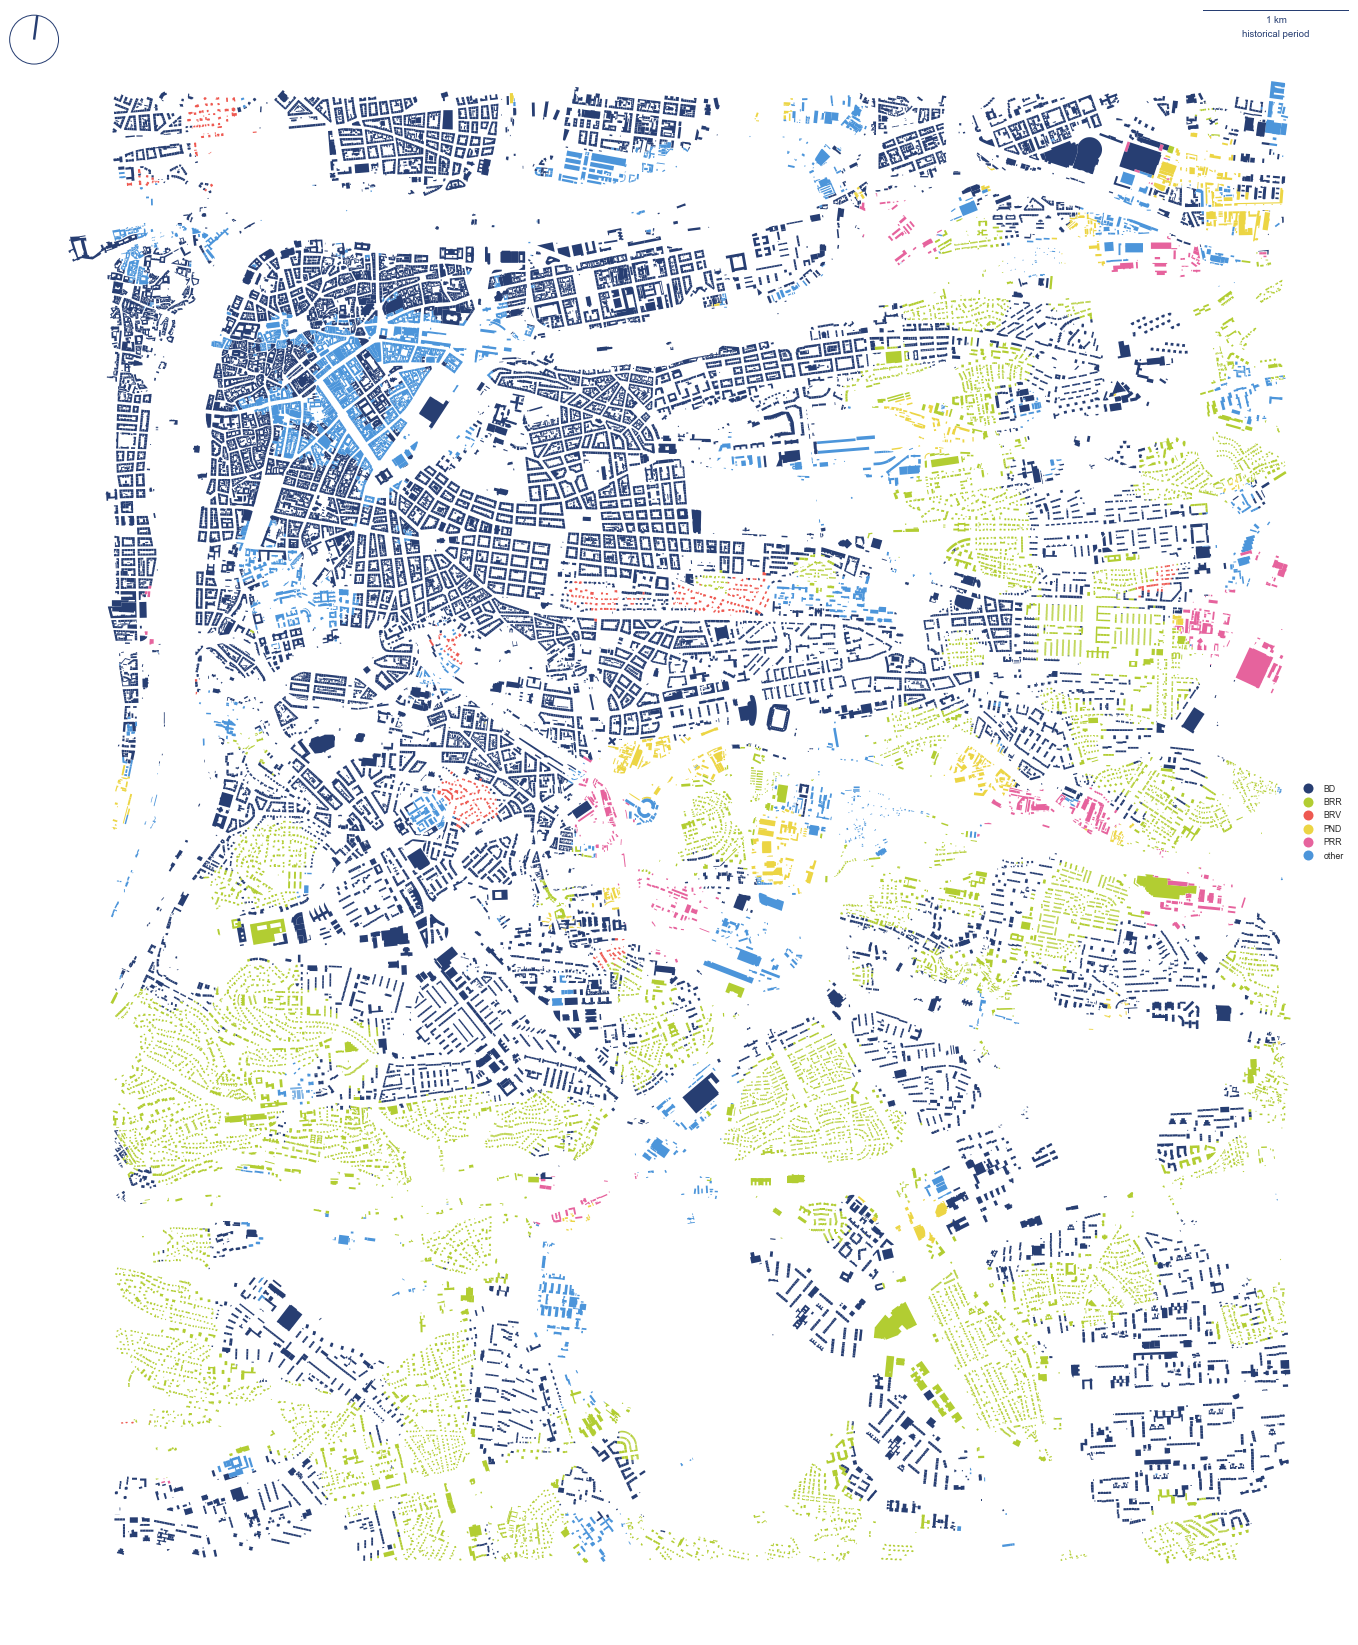

In [106]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  

ax = buildings.cx[-744085:-736085, -1051465:-1041465].plot(
    'lu_gen', categorical=True, figsize=(30, 30), legend=True,
                   legend_kwds=dict(loc='center right', frameon=False), cmap=cmap)
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
for ext in ['pdf', 'png']:
    plt.savefig('figures/PRG_land_use_detail.' + ext, bbox_inches='tight')

In [28]:
import numpy as np

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.02
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58),
  (75, 90, 85), (347, 72, 60), (246, 79, 60)]
pal = [husl.husl_to_hex(*color) for color in colors]

In [120]:
# save all clusters
for cl in range(20):
    data = buildings.loc[buildings['cluster'].isin([cl])]['lu_gen'].value_counts(sort=False, normalize=True)

    sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(ax=ax, x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'],
                palette=pal)
    sns.despine(offset=10)
    ax.set_xticklabels(['Multi-family housing','Single-family housing','Villas','Industry small','Industry large','Other'])
    plt.ylabel('frequency')
    plt.xlabel('land use category')
    plt.ylim(0, 1)
    show_values_on_bars(ax)
    for ext in ['pdf', 'png']:
        plt.savefig('figures/PRG_cluster_' + str(cl) + '_landuse.' + ext, bbox_inches='tight')
    plt.close()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


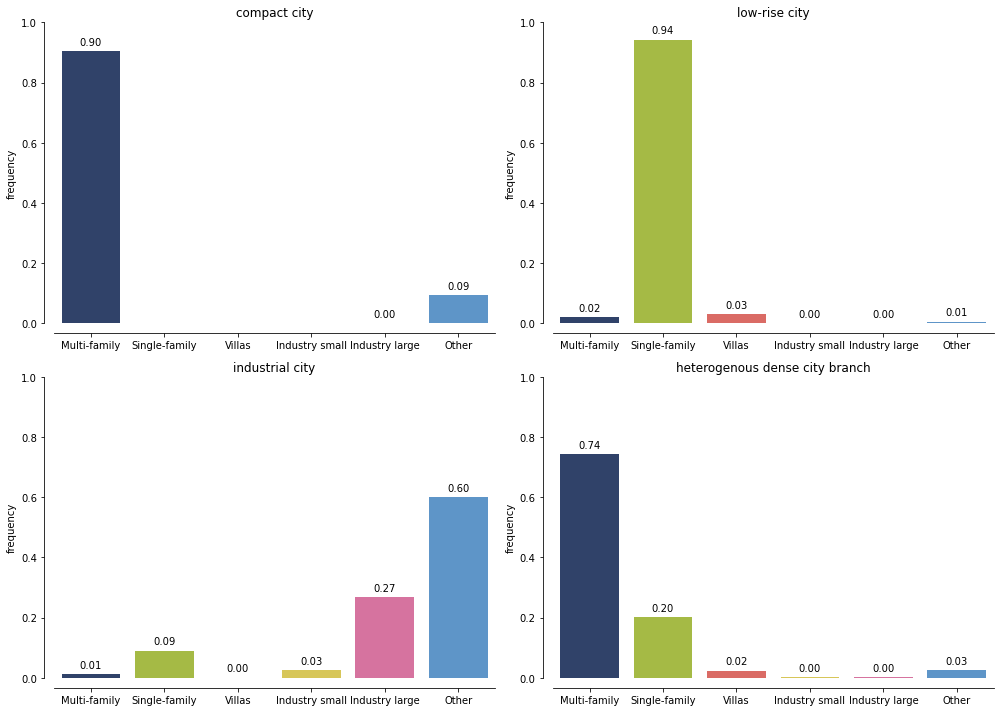

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
labels = ['Multi-family','Single-family','Villas','Industry small','Industry large','Other']

data = buildings.loc[buildings['cluster'].isin([11, 15, 5])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[0, 0], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'],
                palette=pal)
sns.despine(offset=10)
ax[0,0].set_ylabel('frequency')
ax[0,0].set_title('compact city')
ax[0,0].set_ylim(0, 1)
show_values_on_bars(ax[0, 0])
ax[0,0].set_xticklabels(labels, rotation=45)

data = buildings.loc[buildings['cluster'].isin([3, 0, 8, 9, 13, 17])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[0, 1], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[0,1].set_ylabel('frequency')
ax[0,1].set_title('low-rise city')
ax[0,1].set_xticklabels(labels)
ax[0,1].set_ylim(0, 1)
show_values_on_bars(ax[0, 1])

data = buildings.loc[buildings['cluster'].isin([1, 19])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[1, 0], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[1,0].set_ylabel('frequency')
ax[1,0].set_xticklabels(labels)

ax[1,0].set_title('industrial city')
ax[1,0].set_ylim(0, 1)
show_values_on_bars(ax[1, 0])

data = buildings.loc[buildings['cluster'].isin([12, 14, 2, 10])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[1, 1], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[1,1].set_ylabel('frequency')
ax[1,1].set_xticklabels(labels)
ax[1,1].set_title('heterogenous dense city branch')
ax[1,1].set_ylim(0, 1)
show_values_on_bars(ax[1, 1])

plt.tight_layout()
plt.savefig('figures/PRG_branch_landuse_subplot.pdf')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

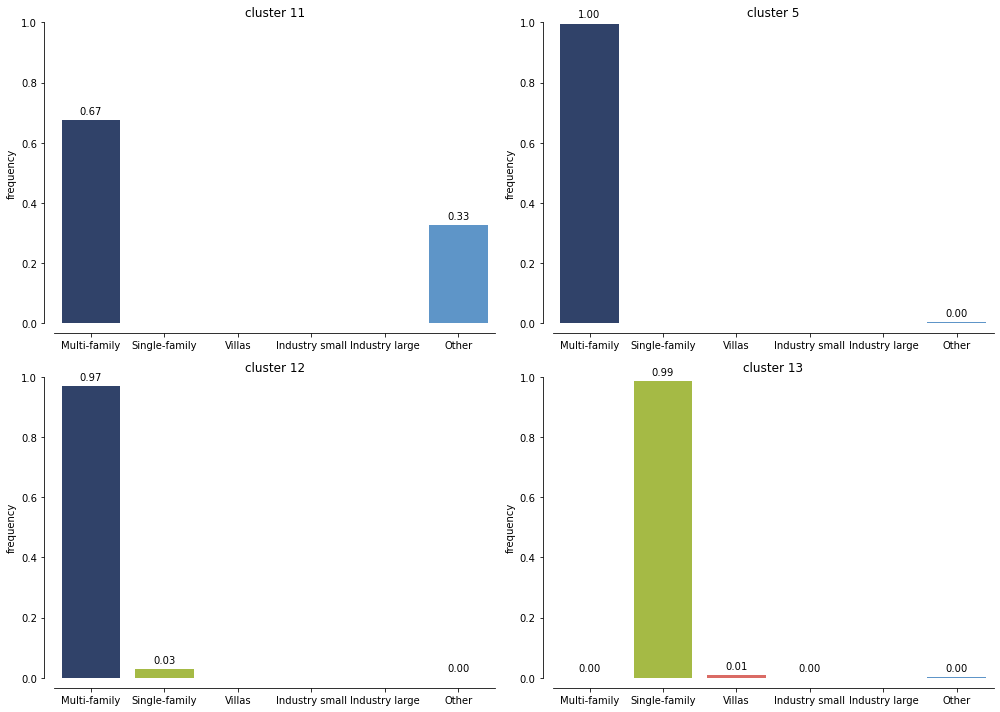

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
labels = ['Multi-family','Single-family','Villas','Industry small','Industry large','Other']

data = buildings.loc[buildings['cluster'].isin([11])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[0, 0], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'],
                palette=pal)
sns.despine(offset=10)
ax[0,0].set_ylabel('frequency')
ax[0,0].set_title('cluster 11')
ax[0,0].set_ylim(0, 1)
show_values_on_bars(ax[0, 0])
ax[0,0].set_xticklabels(labels, rotation=45)

data = buildings.loc[buildings['cluster'].isin([5])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[0, 1], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[0,1].set_ylabel('frequency')
ax[0,1].set_title('cluster 5')
ax[0,1].set_xticklabels(labels)
ax[0,1].set_ylim(0, 1)
show_values_on_bars(ax[0, 1])

data = buildings.loc[buildings['cluster'].isin([12])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[1, 0], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[1,0].set_ylabel('frequency')
ax[1,0].set_xticklabels(labels)

ax[1,0].set_title('cluster 12')
ax[1,0].set_ylim(0, 1)
show_values_on_bars(ax[1, 0])

data = buildings.loc[buildings['cluster'].isin([13])]['lu_gen'].value_counts(sort=False, normalize=True)
sns.barplot(ax=ax[1, 1], x=data.index, y=data, order=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], palette=pal)
sns.despine(offset=10)
ax[1,1].set_ylabel('frequency')
ax[1,1].set_xticklabels(labels)
ax[1,1].set_title('cluster 13')
ax[1,1].set_ylim(0, 1)
show_values_on_bars(ax[1, 1])

plt.tight_layout()
plt.savefig('figures/PRG_cluster_landuse_subplot.pdf')

In [26]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  
for cl in tqdm(range(20), total=20):

    # requires geopandas PR 1159
    sub = buildings[buildings.cluster == cl]
    bounds = sub.total_bounds
    ax = sub.plot('lu_gen', categorical=True, figsize=(30, 30), cmap=cmap, zorder=2,
                  categories=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'], legend=True,
                    legend_kwds=dict(loc='center right', frameon=False))
    buildings.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot('lu_gen',ax=ax, categorical=True, cmap=cmap,
                    alpha=.2, zorder=1,
                    categories=['BD', 'BRR', 'BRV', 'PND', 'PRR', 'other'])
    ax.set_axis_off()


    # add scalebar
    scalebar = ScaleBar(dx=1,
                        color=c,
                        location=1,
                        height_fraction=0.001,
                        #fixed_value=1000,
                        label='cluster {} and historical period'.format(cl),
                        label_loc='bottom'
                        )
    ax.add_artist(scalebar)

    # add arrow
    north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
    for ext in ['pdf', 'png']:
        plt.savefig('figures/PRG_cluster_{}_landuse_map.'.format(cl) + ext, bbox_inches='tight')
    plt.close()



100%|██████████| 20/20 [27:27<00:00, 82.37s/it]


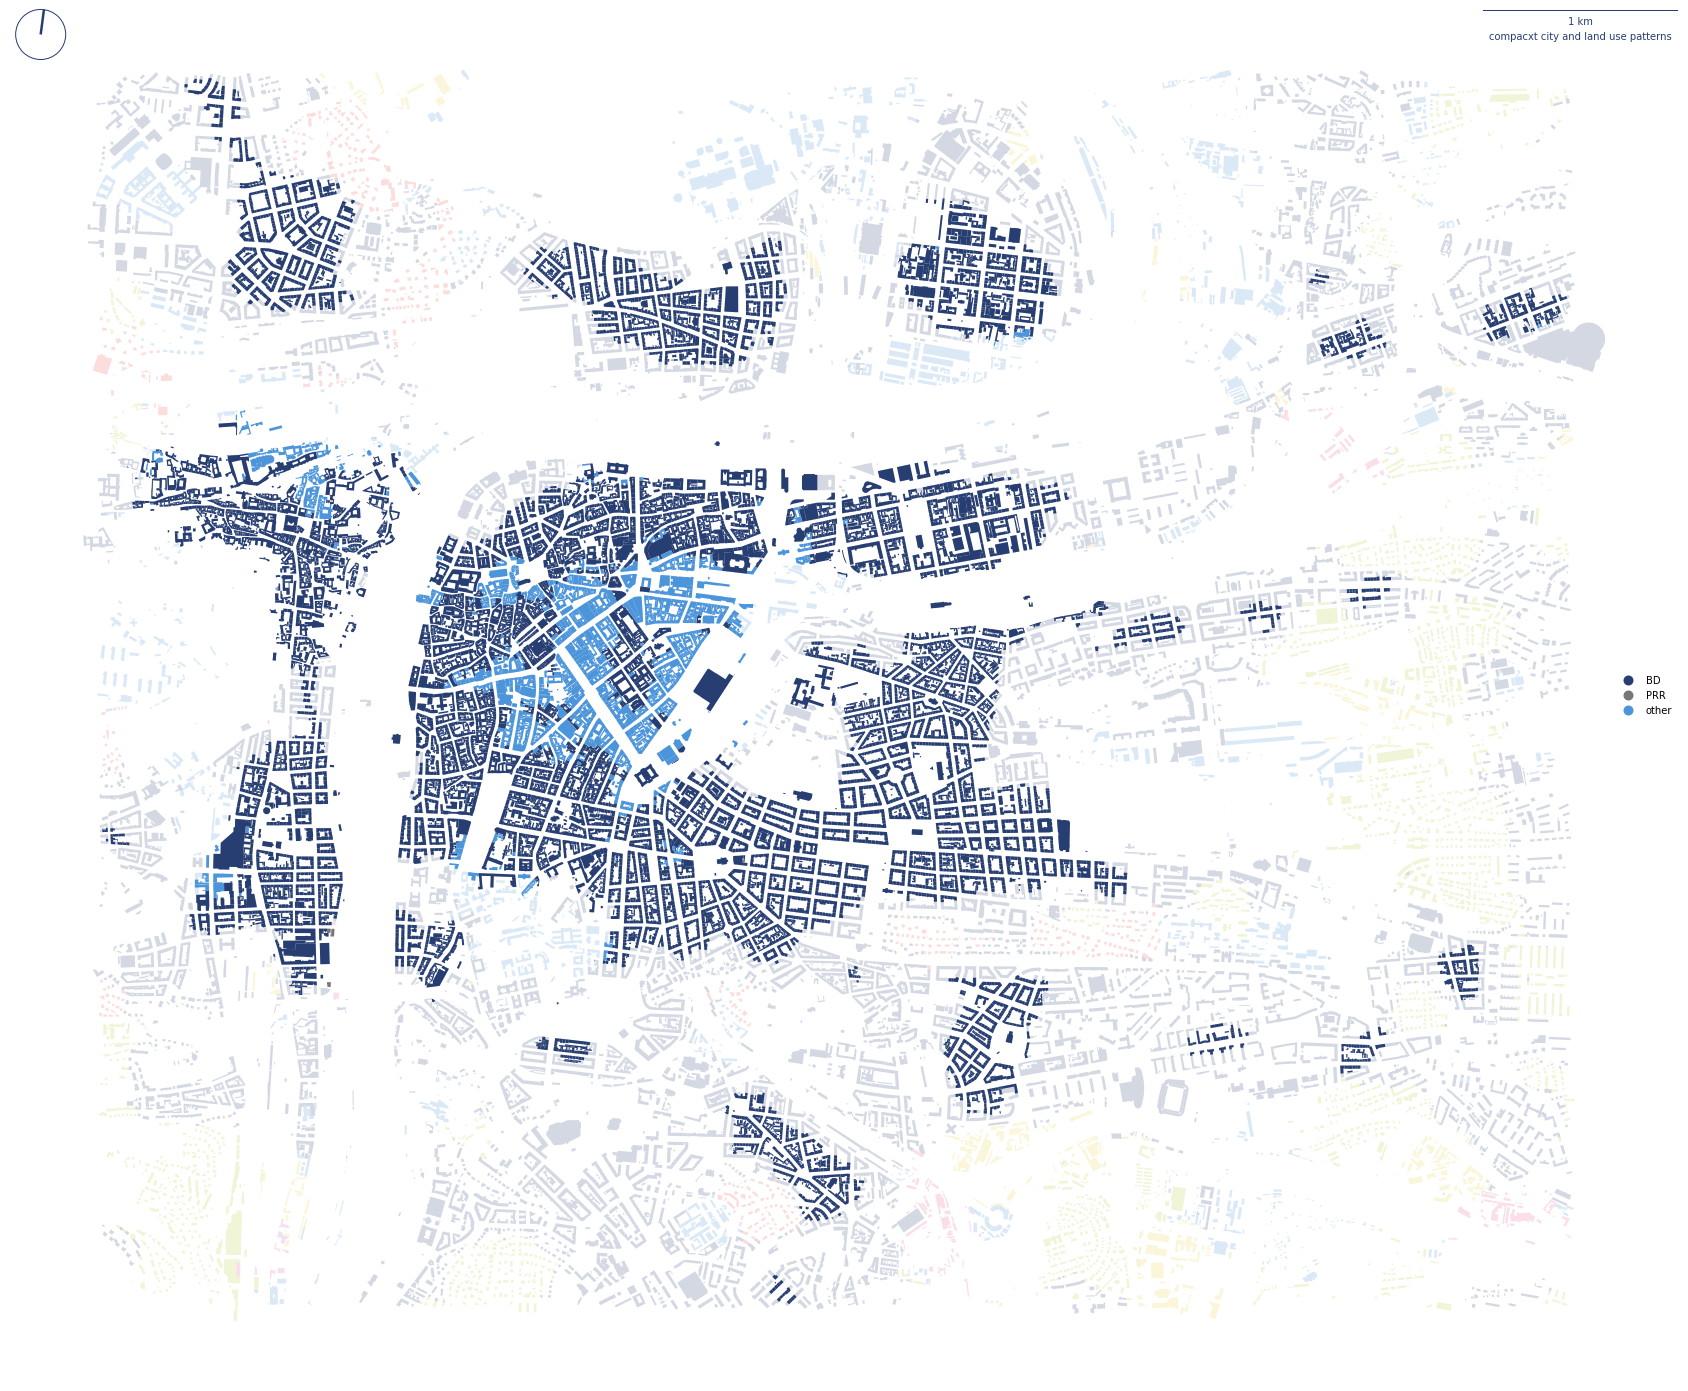

In [31]:
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50),
          (75, 90, 85), (347, 72, 60), (246, 79, 60)]
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap([husl.husl_to_hex(*color) for color in colors])  


sub = buildings[buildings.cluster.isin([11, 15, 5])]
bounds = sub.total_bounds
ax = sub.plot('lu_gen', categorical=True, figsize=(30, 30), cmap=cmap, zorder=2,
             legend=True,
                legend_kwds=dict(loc='center right', frameon=False))
buildings.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot('lu_gen',ax=ax, categorical=True, cmap=cmap,
                alpha=.2, zorder=1)
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='compacxt city and land use patterns',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, -7.5, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
for ext in ['pdf', 'png']:
    plt.savefig('figures/PRG_cluster_{}_landuse_map.'.format('branch0') + ext, bbox_inches='tight')
#plt.close()



## statistics

In [28]:
buildings[['cluster', 'lu_gen']]

cluster lu_gen
0           0.0    PRR
1           7.0     BD
2           5.0    BRR
3           5.0    BRR
4           3.0     BD
...         ...    ...
140403      7.0     BD
140404      5.0    BRR
140405      6.0     BD
140406      6.0     BD
140407      2.0    BRR

[140408 rows x 2 columns]

In [29]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [30]:
cramers_v(buildings.cluster, buildings.lu_gen)

0.4679565013348652

Cramer's V Coefficient (V)

Useful for comparing multiple X2 test statistics and is generalizable across contingency tables of varying sizes. It is not affected by sample size and therefore is very useful in situations where you suspect a statistically significant chi-square was the result of large sample size instead of any substantive relationship between the variables. It is interpreted as a measure of the relative (strength) of an association between two variables. The coefficient ranges from 0 to 1 (perfect association). In practice, you may find that a Cramer's V of .10 provides a good minimum threshold for suggesting there is a substantive relationship between two variables. (http://www.acastat.com/statbook/chisqassoc.htm)

.5                   high association

.3 to .5             moderate association

.1 to .3             low association

0 to .1              little if any association

The resulting value of 0.5 indicates moderate to high relationship between clustering and generalised land use.

#### Chi-square test of independence of variables in a contingency table

In [31]:
confusion_matrix = pd.crosstab(buildings.cluster, buildings.lu_gen)
chi, p, dof, exp = ss.chi2_contingency(confusion_matrix)

In [32]:
chi

153672.72537585945

In [33]:
p

0.0

In [34]:
dof

45

p-value is < 0.001

there is a significant dependency between variables

In [8]:
interp = pd.read_csv('/Users/martin/Dropbox/Academia/Data/Geo/Prague/Validation/land_use_interpolated.csv', index_col=0)
interp

land_use_3
uID              
0             PRR
1              BD
2             BRR
3             BRR
4              BD
...           ...
140457         BD
140458        BRR
140459         BD
140460         BD
140461        BRR

[140408 rows x 1 columns]

In [10]:
data = clusters.merge(interp, on='uID')

In [14]:
counts = data.land_use_3.value_counts()

NameError: name 'data' is not defined

In [13]:
generalised = []
major = counts[counts>1400].index
for _, use in data.land_use_3.iteritems():
    if use in major:
        generalised.append(use)
    else:
        generalised.append('other')
data['lu_gen'] = generalised

NameError: name 'counts' is not defined

In [13]:
confusion_matrix = pd.crosstab(data.cluster, data.lu_gen)
confusion_matrix

lu_gen     BD    BRR  BRV  PND  PRR  other
cluster                                   
0          91  14412  819    0    0     15
1          30    304    2   72  287   1343
2        6019   5426  487    3    3     78
3         201   3817    0    0    0    115
4         312   1065    1  733  546   2624
5        5905      0    0    0    0     25
6        2176   7038  255  214  146    500
7        2489    573   15  221  151    691
8         287   7321  236    0    0      1
9         191   7292  160   73   20    126
10       6609    389  196    1    1      7
11       1461      0    0    0    0    706
12       6684    199    0    0    0      2
13          6  14794  130    8    0     54
14       3775    281   59  104   64    701
15       2731      0    0    0    6    323
16        431   2632   78   49   97    261
17        505  11127  466   11    2     34
18         42   7384   61   41    6   1230
19         18     31    0   27  706    874

In [ ]:
print(confusion_matrix.to_markdown())

# Revision

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import husl
from legendgram import legendgram
import mapclassify
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from shapely.geometry import Point

from tqdm import tqdm
from download import download

In [3]:
clusters = pd.read_csv('prg_cluster_labels_10.csv', index_col=0)

In [5]:
clusters

cluster     uID
0             0       0
1             7       1
2             5       2
3             5       3
4             3       4
...         ...     ...
140310        7  140457
140311        5  140458
140312        6  140459
140313        6  140460
140314        2  140461

[140315 rows x 2 columns]

In [6]:
years_path = download("https://www.dropbox.com/s/pjlgpqpcmpxhprg/land_use_interpolated.csv?dl=1", "land_use_interpolated.csv")

Successfully downloaded file to land_use_interpolated.csv


In [4]:
years = pd.read_csv('land_use_interpolated.csv', index_col=0)

In [5]:
years

land_use_3
uID              
0             PRR
1              BD
2             BRR
3             BRR
4              BD
...           ...
140457         BD
140458        BRR
140459         BD
140460         BD
140461        BRR

[140408 rows x 1 columns]

In [6]:
buildings = gpd.read_file('geometry.gpkg', layer='buildings')

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [7]:
joined = clusters.merge(years.reset_index()[['uID', 'land_use_3']], on='uID', how='left')

In [21]:
counts = joined.land_use_3.value_counts()

In [22]:
generalised = []
major = counts[counts>1400].index
for _, use in joined.land_use_3.iteritems():
    if use in major:
        generalised.append(use)
    else:
        generalised.append('other')
joined['lu_gen'] = generalised

In [23]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [24]:
cramers_v(joined.cluster, joined.lu_gen)

0.4679565013348652

The resulting value of 0.5 indicates moderate relationship between clustering and historical origin.

#### Chi-square test of independence of variables in a contingency table

In [25]:
confusion_matrix = pd.crosstab(joined.cluster, joined.lu_gen)
chi, p, dof, exp = ss.chi2_contingency(confusion_matrix)

In [26]:
p

0.0

In [27]:
dof

45

In [28]:
chi

153672.72537585945

In [30]:
joined.cluster.size

140315

p-value is < 0.001

there is a significant dependency between variables

In [23]:
confusion_matrix = pd.crosstab(joined.cluster, joined.land_use_3)

In [31]:
print(confusion_matrix.to_markdown())

|   cluster |    BD |   BRR |   BRV |   PND |   PRR |   other |
|----------:|------:|------:|------:|------:|------:|--------:|
|         0 |   112 |   617 |     3 |   322 |  1138 |    3497 |
|         1 |   437 | 27953 |  1164 |     3 |     0 |      33 |
|         2 |  3706 |  7238 |   203 |   972 |   789 |    2830 |
|         3 |  8472 |   577 |   136 |    93 |    26 |     626 |
|         4 |  9553 |   748 |     0 |     0 |     0 |      17 |
|         5 |    75 | 21590 |   147 |    50 |    22 |    1156 |
|         6 | 10070 |   231 |   153 |     0 |     0 |      34 |
|         7 |  2374 |     6 |     0 |     0 |     0 |    1057 |
|         8 |  4296 | 18110 |  1080 |   117 |    60 |     340 |
|         9 |   868 |  7015 |    79 |     0 |     0 |     120 |
